In [1]:
import os
os.environ["PYSTEPSRC"]='/home/allen/Documents/Projects/Ensemble_Nowcast/pysteps-1.3.2/pysteps'

In [2]:
from pylab import *
from datetime import datetime
from pprint import pprint
from pysteps import io, nowcasts, rcparams
from pysteps.motion.lucaskanade import dense_lucaskanade
from pysteps.postprocessing.ensemblestats import excprob
from pysteps.utils import conversion, dimension, transformation
from pysteps.visualization import plot_precip_field, motionfields, animate, quiver
from osgeo import gdal


Pysteps configuration file found at: /home/allen/Documents/Projects/Ensemble_Nowcast/pysteps-1.3.2/pysteps/pystepsrc



In [3]:
n_ens_members= 10
n_leadtimes=30
seed=24

date = datetime.strptime("20170826", "%Y%m%d")
data_source = "usr"

# Load data source config
root_path = rcparams.data_sources[data_source]["root_path"]
path_fmt = rcparams.data_sources[data_source]["path_fmt"]
fn_pattern = rcparams.data_sources[data_source]["fn_pattern"]
fn_ext = rcparams.data_sources[data_source]["fn_ext"]
importer_name = rcparams.data_sources[data_source]["importer"]
importer_kwargs = rcparams.data_sources[data_source]["importer_kwargs"]
timestep = 10

In [4]:
fns = io.find_by_date(
    date, root_path, path_fmt, fn_pattern, fn_ext, timestep, num_prev_files=0
)

In [5]:
importer = io.get_method(importer_name, "importer")
R, _, metadata = io.read_timeseries(fns, importer, **importer_kwargs)

In [6]:
pprint(metadata)

{'accutime': 2.0,
 'institution': 'Users',
 'projection': '+proj=longlat +datum=WGS84 +no_defs',
 'threshold': 0.20000000298023224,
 'timestamps': array([datetime.datetime(2017, 8, 26, 0, 0)], dtype=object),
 'transform': None,
 'unit': '',
 'x1': -95.99575701078582,
 'x2': -94.90164298921418,
 'xpixelsize': 0.0013676425269645602,
 'y1': 29.4849,
 'y2': 30.3725,
 'yorigin': 'upper',
 'ypixelsize': 0.0013676425269645587,
 'zerovalue': 0.0}


# Generate nowcast spacing every 1 hour

In [7]:
def export_geotif(dst,arr,sample,mem=10):
    sample=gdal.Open(sample)
    
    for i in range(mem):
        rows,cols=arr[i].shape
        prefix= dst[:-4]
        prefix+= '_mem%02d'%i
        driver = gdal.GetDriverByName("GTiff")
        outdata = driver.Create(prefix+'.tif', cols, rows, 1, gdal.GDT_Float32)
        outdata.SetGeoTransform(sample.GetGeoTransform())##sets same geotransform as input
        outdata.SetProjection(sample.GetProjection())##sets same projection as input

        outdata.GetRasterBand(1).WriteArray(arr[i])
        outdata.GetRasterBand(1).SetNoDataValue(-9999.)##if you want these values transparent
        outdata.FlushCache() ##saves to disk!!
        outdata = None


In [8]:
repos= pd.date_range('201708251200', '201708310000', freq='1H')
sample_pth='/home/allen/Documents/Projects/Ensemble_Nowcast/MRMS/20170826/PrecipRate_00.00_20170825-093400.grib2-var0-z0.tif'

In [9]:
#read in HRRR windfiled
U_wind= gdal.Open('../hrrr.wind_vel_u_warp.tif').ReadAsArray()
V_wind= -gdal.Open('../hrrr.wind_vel_v_warp.tif').ReadAsArray()
VELOCITY= np.stack([U_wind, V_wind])

In [10]:
# read the earlier three files
base_dir='/home/allen/Documents/Projects/Ensemble_Nowcast/MRMS/20170826'
save_dir='/home/allen/Documents/Projects/Ensemble_Nowcast/extrapolation/20170826'
for repo in [pd.to_datetime('201708261200')]:
    
    fnames= np.array([repo-pd.Timedelta('18M'), repo-pd.Timedelta('12M'), repo-pd.Timedelta('6M')])
    R= np.stack([gdal.Open(os.path.join(base_dir, fname.strftime('PrecipRate_00.00_%Y%m%d-%H%M%S.grib2-var0-z0.tif'))).ReadAsArray() \
                     for fname in fnames],axis=0)
    metadata['timestamps']= fnames
    metadata['unit']='mm/h'
    R, metadata = transformation.dB_transform(R, metadata, threshold=0.1, zerovalue=-15.0)
    R[~np.isfinite(R)] = -15.0
#     V = dense_lucaskanade(R) 
#     HRRR velocity in m/s; the desired unit is in km/6M
    V= VELOCITY * 3.6 /10
    nowcast_method = nowcasts.get_method("steps")
    R_f = nowcast_method(
        R[-3:, :, :],
        V,
        n_leadtimes,
        n_ens_members,
        n_cascade_levels=6,
        R_thr=-10.0,
        kmperpixel=1.0,
        timestep=10,
        decomp_method="fft",
        bandpass_filter_method="gaussian",
        noise_method="nonparametric",
        vel_pert_method="bps",
        mask_method="incremental",
        seed=seed,
        num_workers=3,
    )
    R_f = transformation.dB_transform(R_f, threshold=-10.0, inverse=True)[0]
    if ~os.path.exists(os.path.join(save_dir,repo.strftime('%Y%m%d%H'))):
        os.system('mkdir %s'%(os.path.join(save_dir,repo.strftime('%Y%m%d%H'))))
        
    for h in range(n_leadtimes):
        dst_name= (repo+pd.Timedelta('6M')*h).strftime('PrecipRate_00.00_%Y%m%d-%H%M%S.grib2-var0-z0.tif')
        export_geotif(os.path.join(save_dir,repo.strftime('%Y%m%d%H'),dst_name), R_f[:,h,:,:], sample_pth)

Computing STEPS nowcast:
------------------------

Inputs:
-------
input dimensions: 649x800
km/pixel:         1
time step:        10 minutes

Methods:
--------
extrapolation:          semilagrangian
bandpass filter:        gaussian
decomposition:          fft
noise generator:        nonparametric
noise adjustment:       no
velocity perturbator:   bps
conditional statistics: no
precip. mask method:    incremental
probability matching:   cdf
FFT method:             numpy
domain:                 spatial

Parameters:
-----------
number of time steps:     30
ensemble size:            10
parallel threads:         3
number of cascade levels: 6
order of the AR(p) model: 2
velocity perturbations, parallel:      10.88,0.23,-7.68
velocity perturbations, perpendicular: 5.76,0.31,-2.72
precip. intensity threshold: -10
************************************************
* Correlation coefficients for cascade levels: *
************************************************
-----------------------------------

In [13]:
dr= pd.date_range('20170826120000', '20170826130000', freq='0.1H')
QPE_dir='/home/allen/Documents/Projects/Ensemble_Nowcast/MRMS/20170826'
QPF_dir='/home/allen/Documents/Projects/Ensemble_Nowcast/extrapolation/20170826'
T= []
for hour in dr:
    fname= hour.strftime('PrecipRate_00.00_%Y%m%d-%H%M%S.grib2-var0-z0.tif')
    T.append(gdal.Open(os.path.join(QPE_dir,fname)).ReadAsArray())
T= np.stack(T)

animation/None_frame_00.png saved.


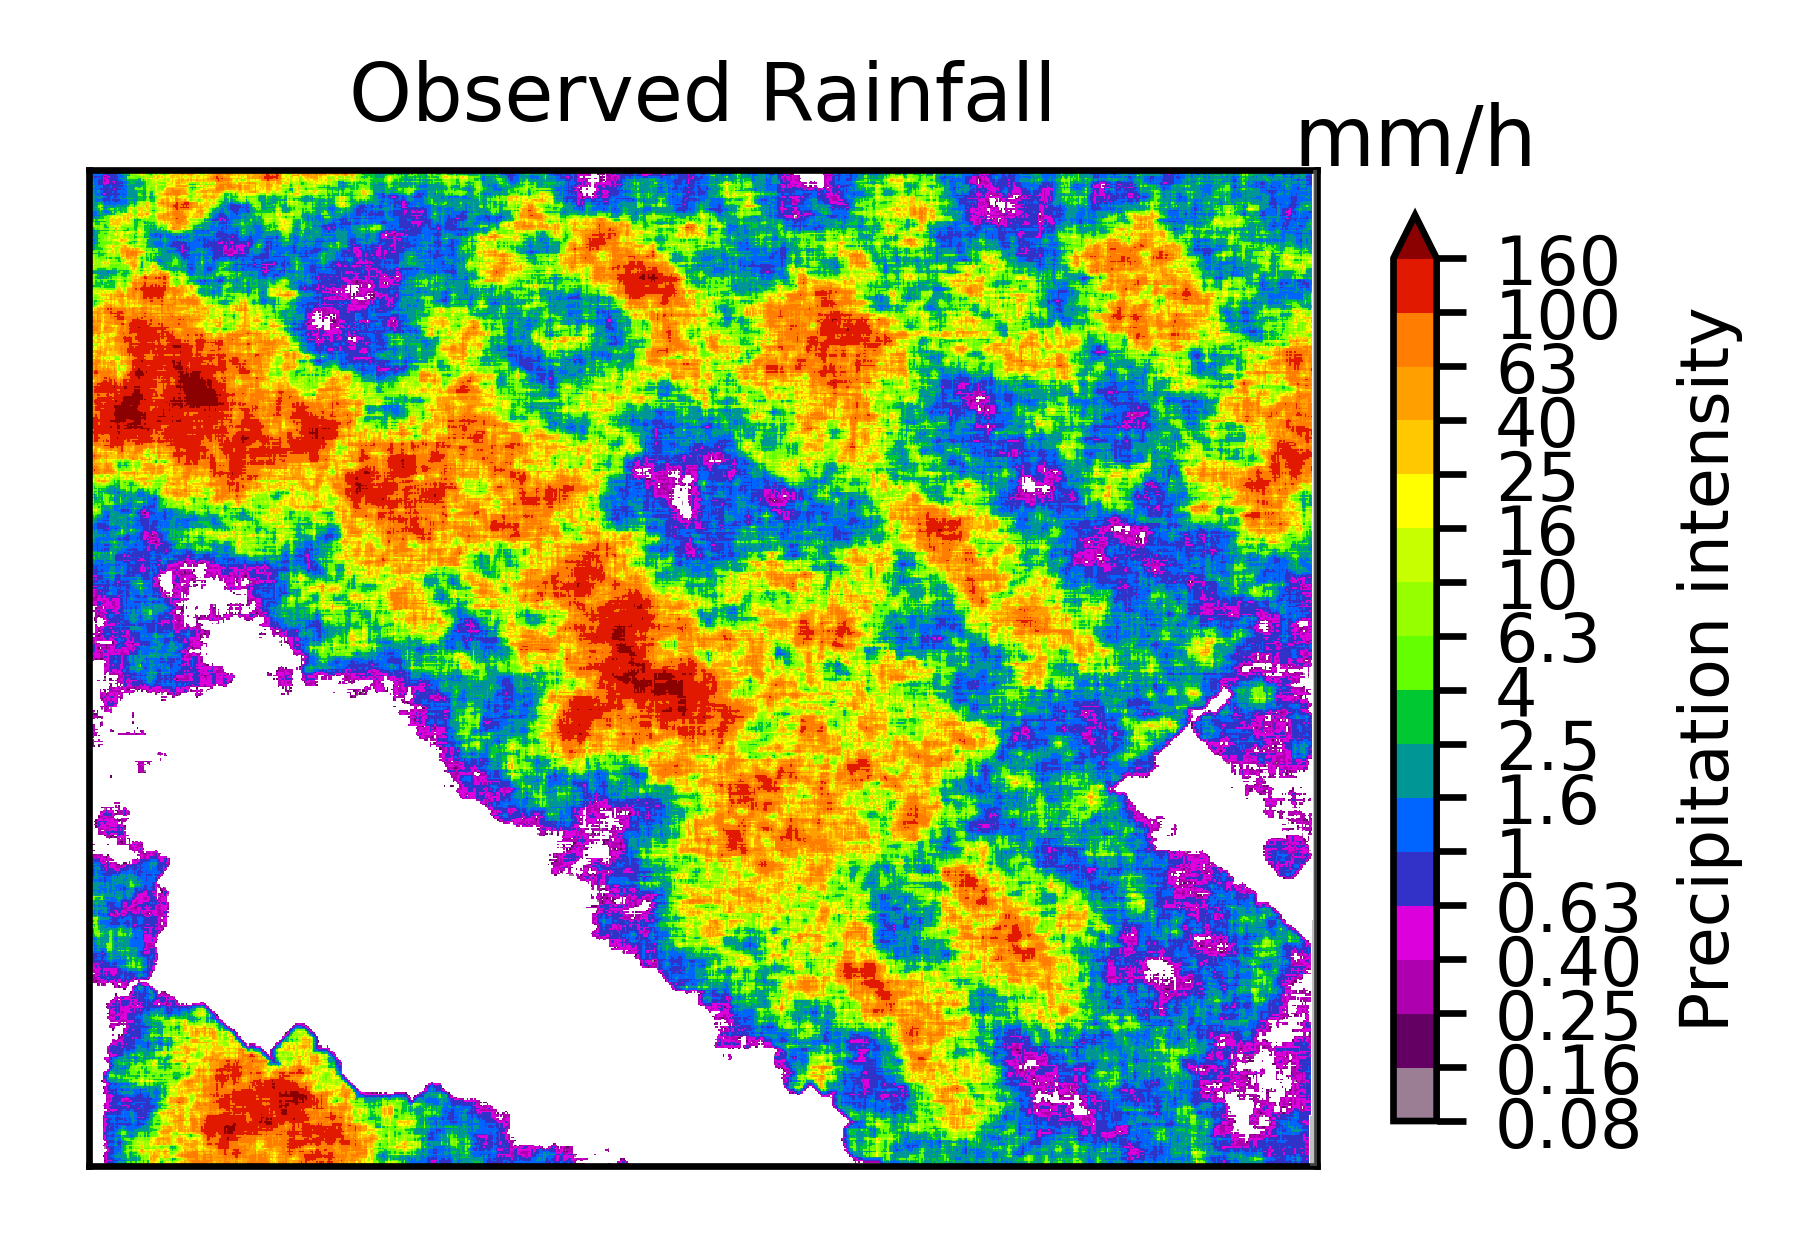

animation/None_frame_01.png saved.


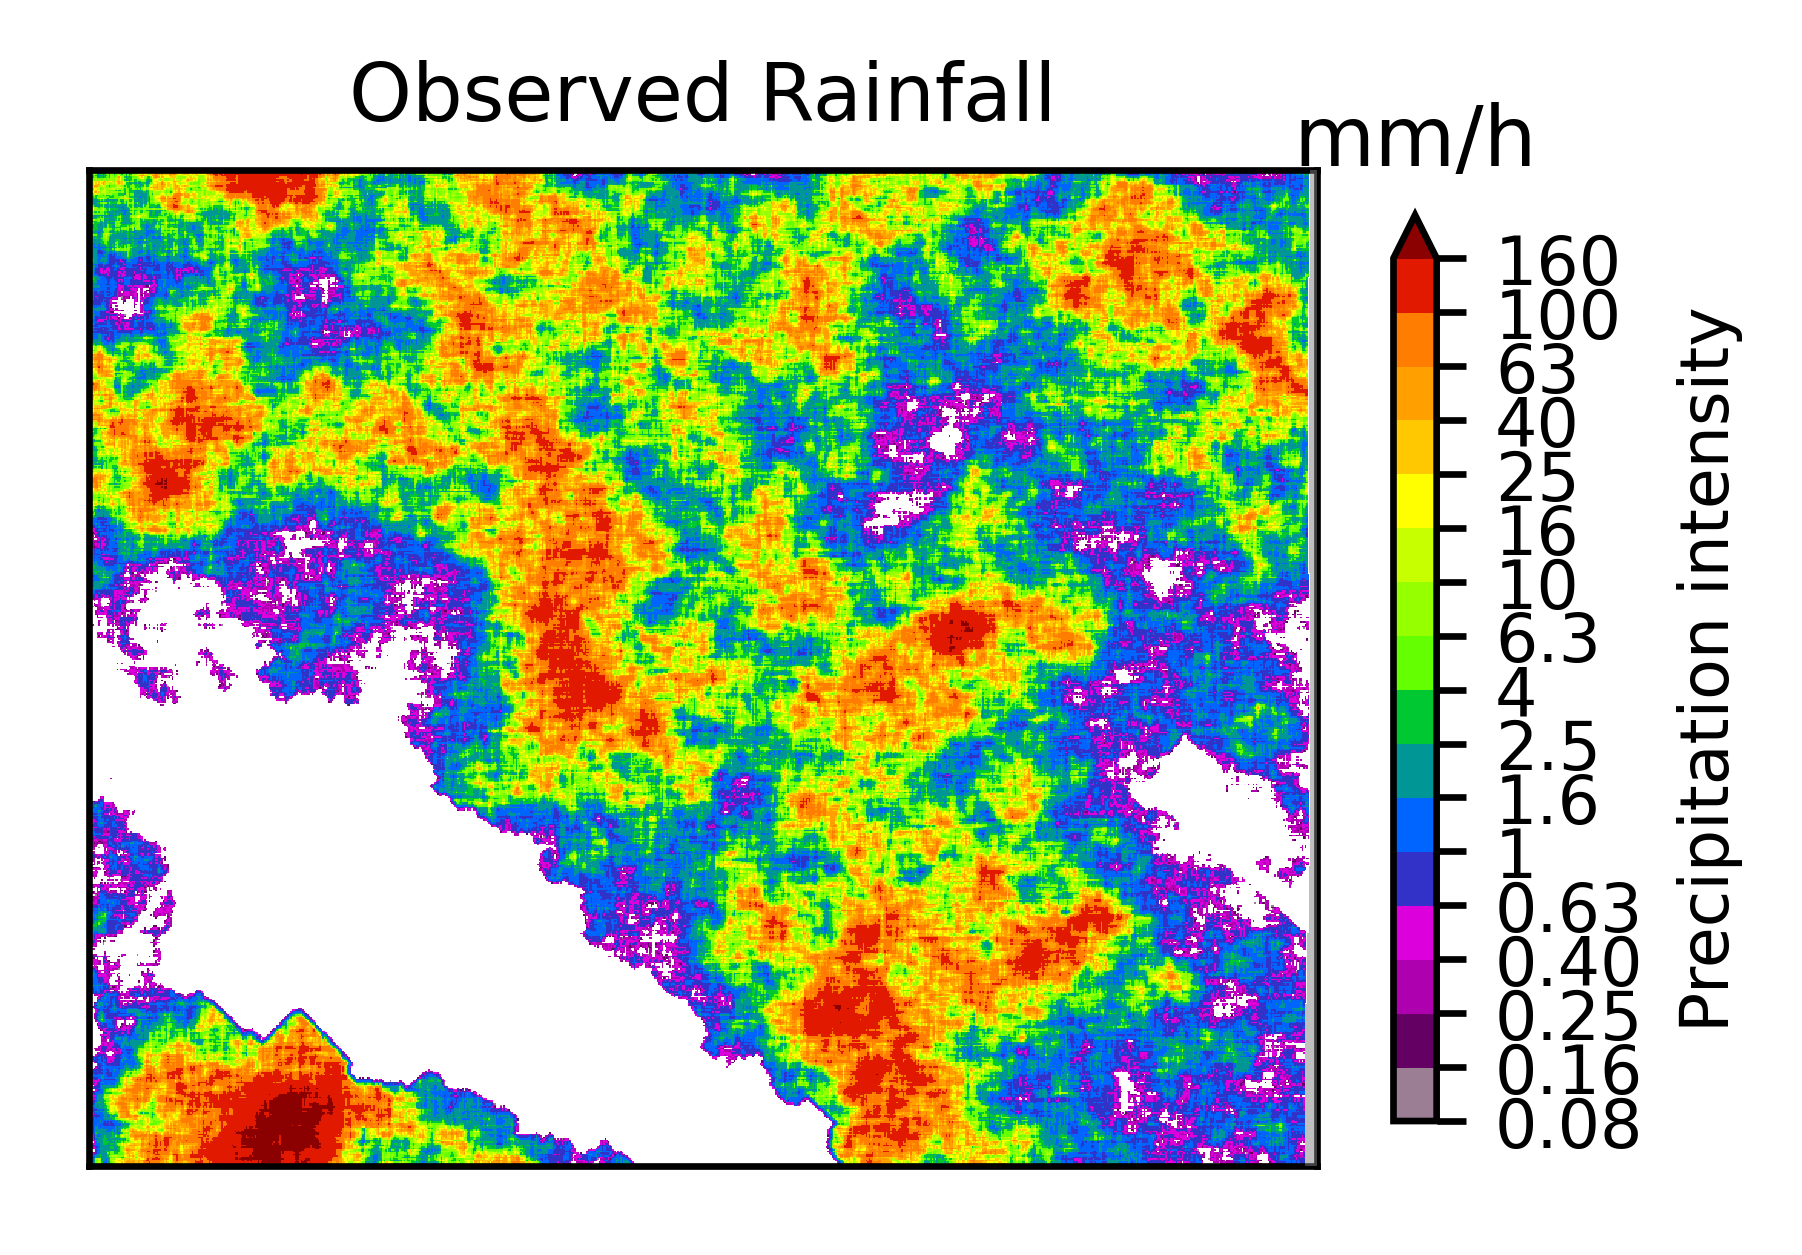

animation/None_frame_02.png saved.


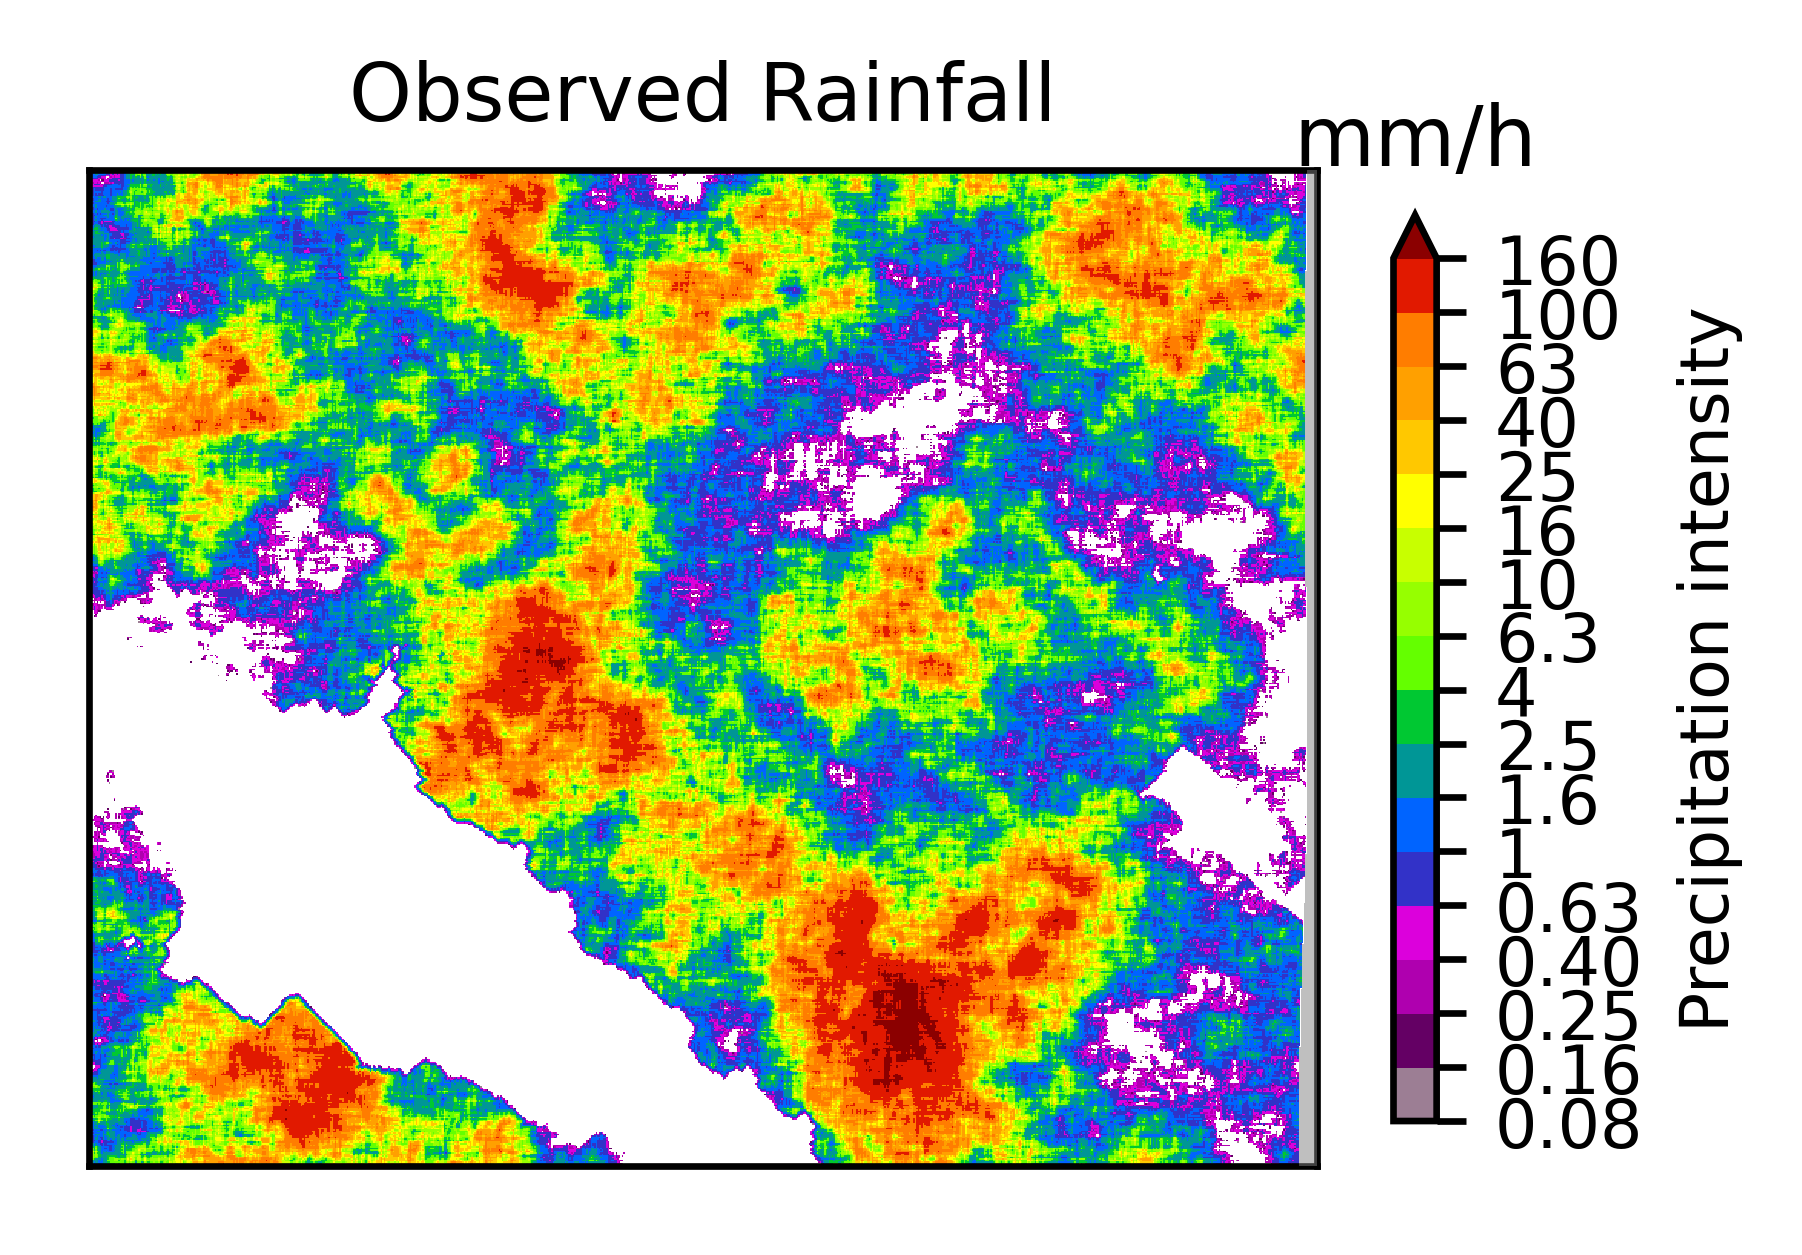

animation/None_frame_03.png saved.


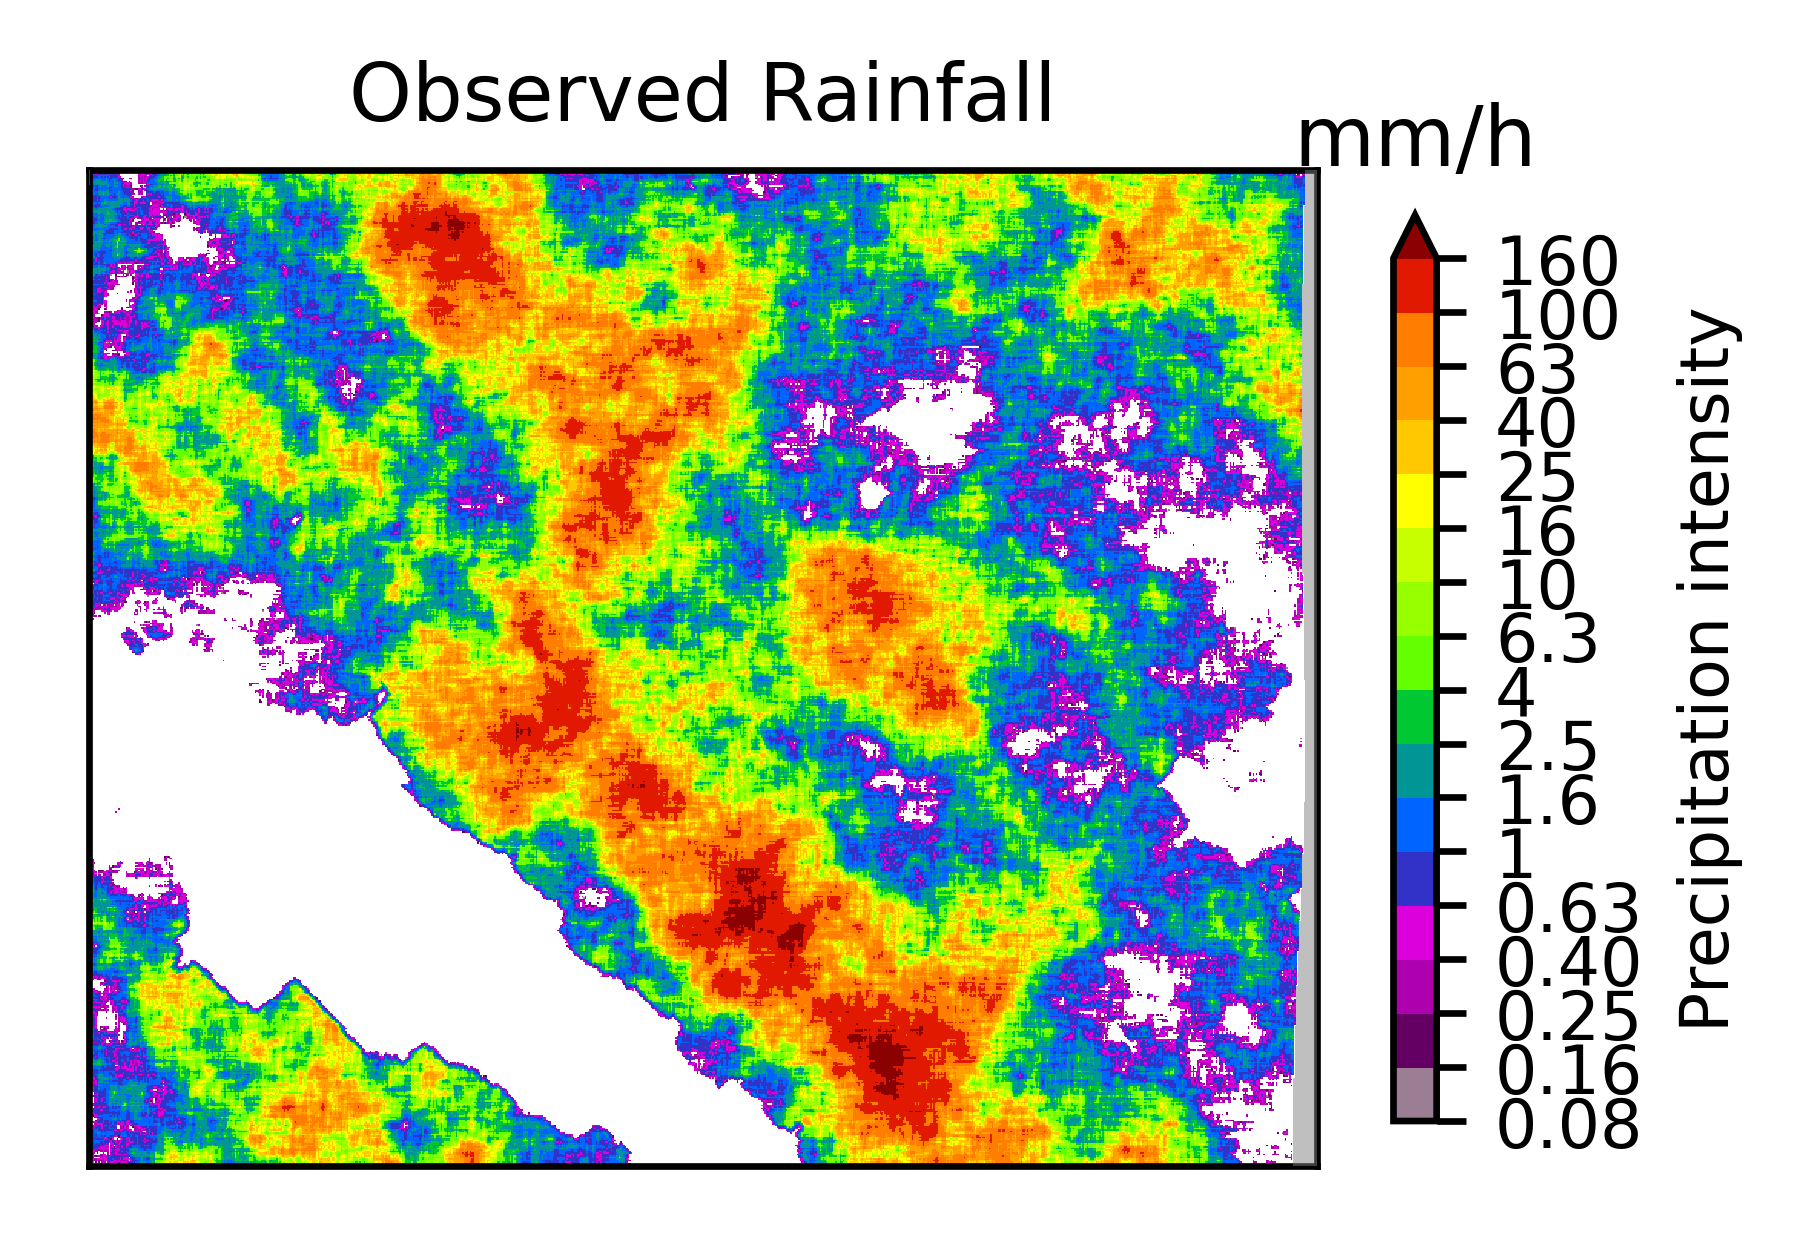

animation/None_frame_04.png saved.


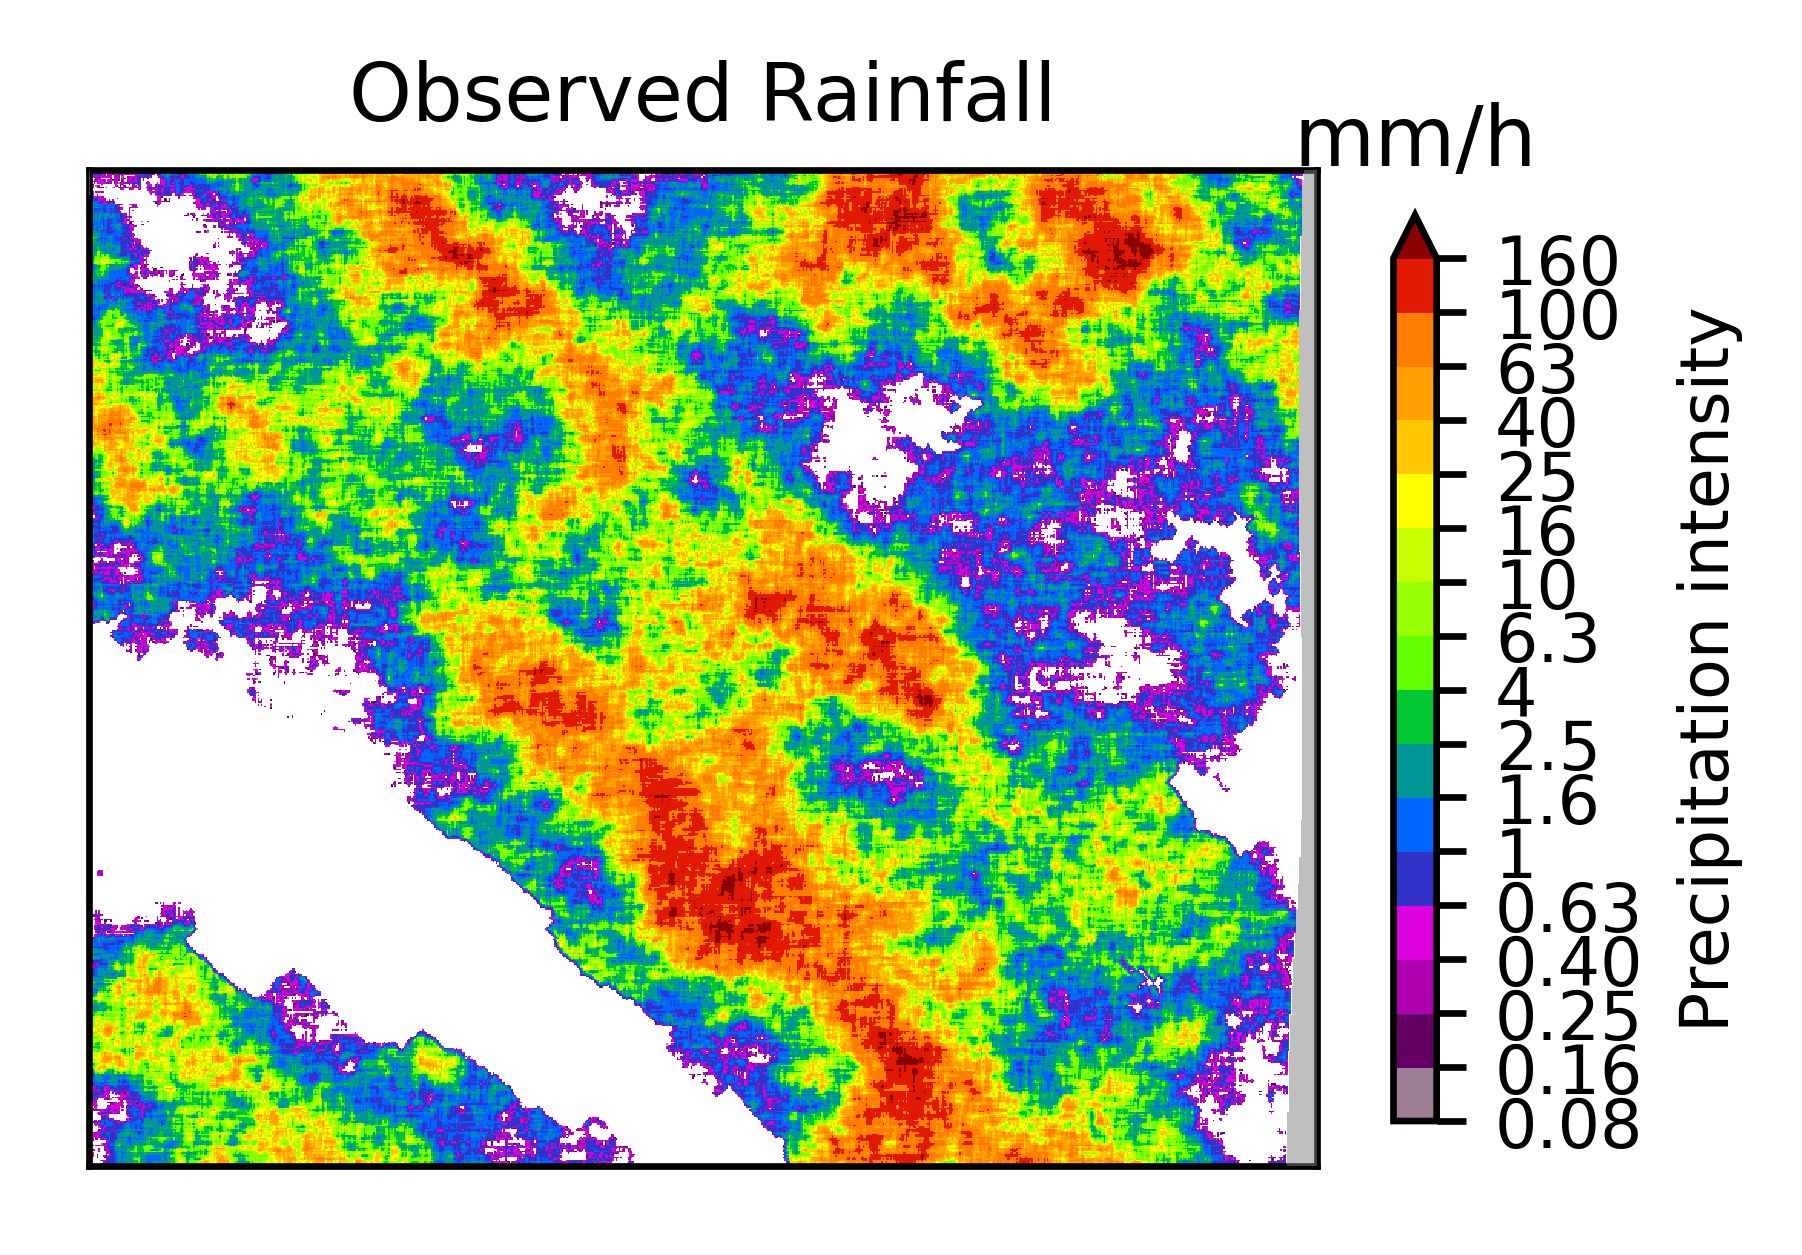

animation/None_frame_05.png saved.


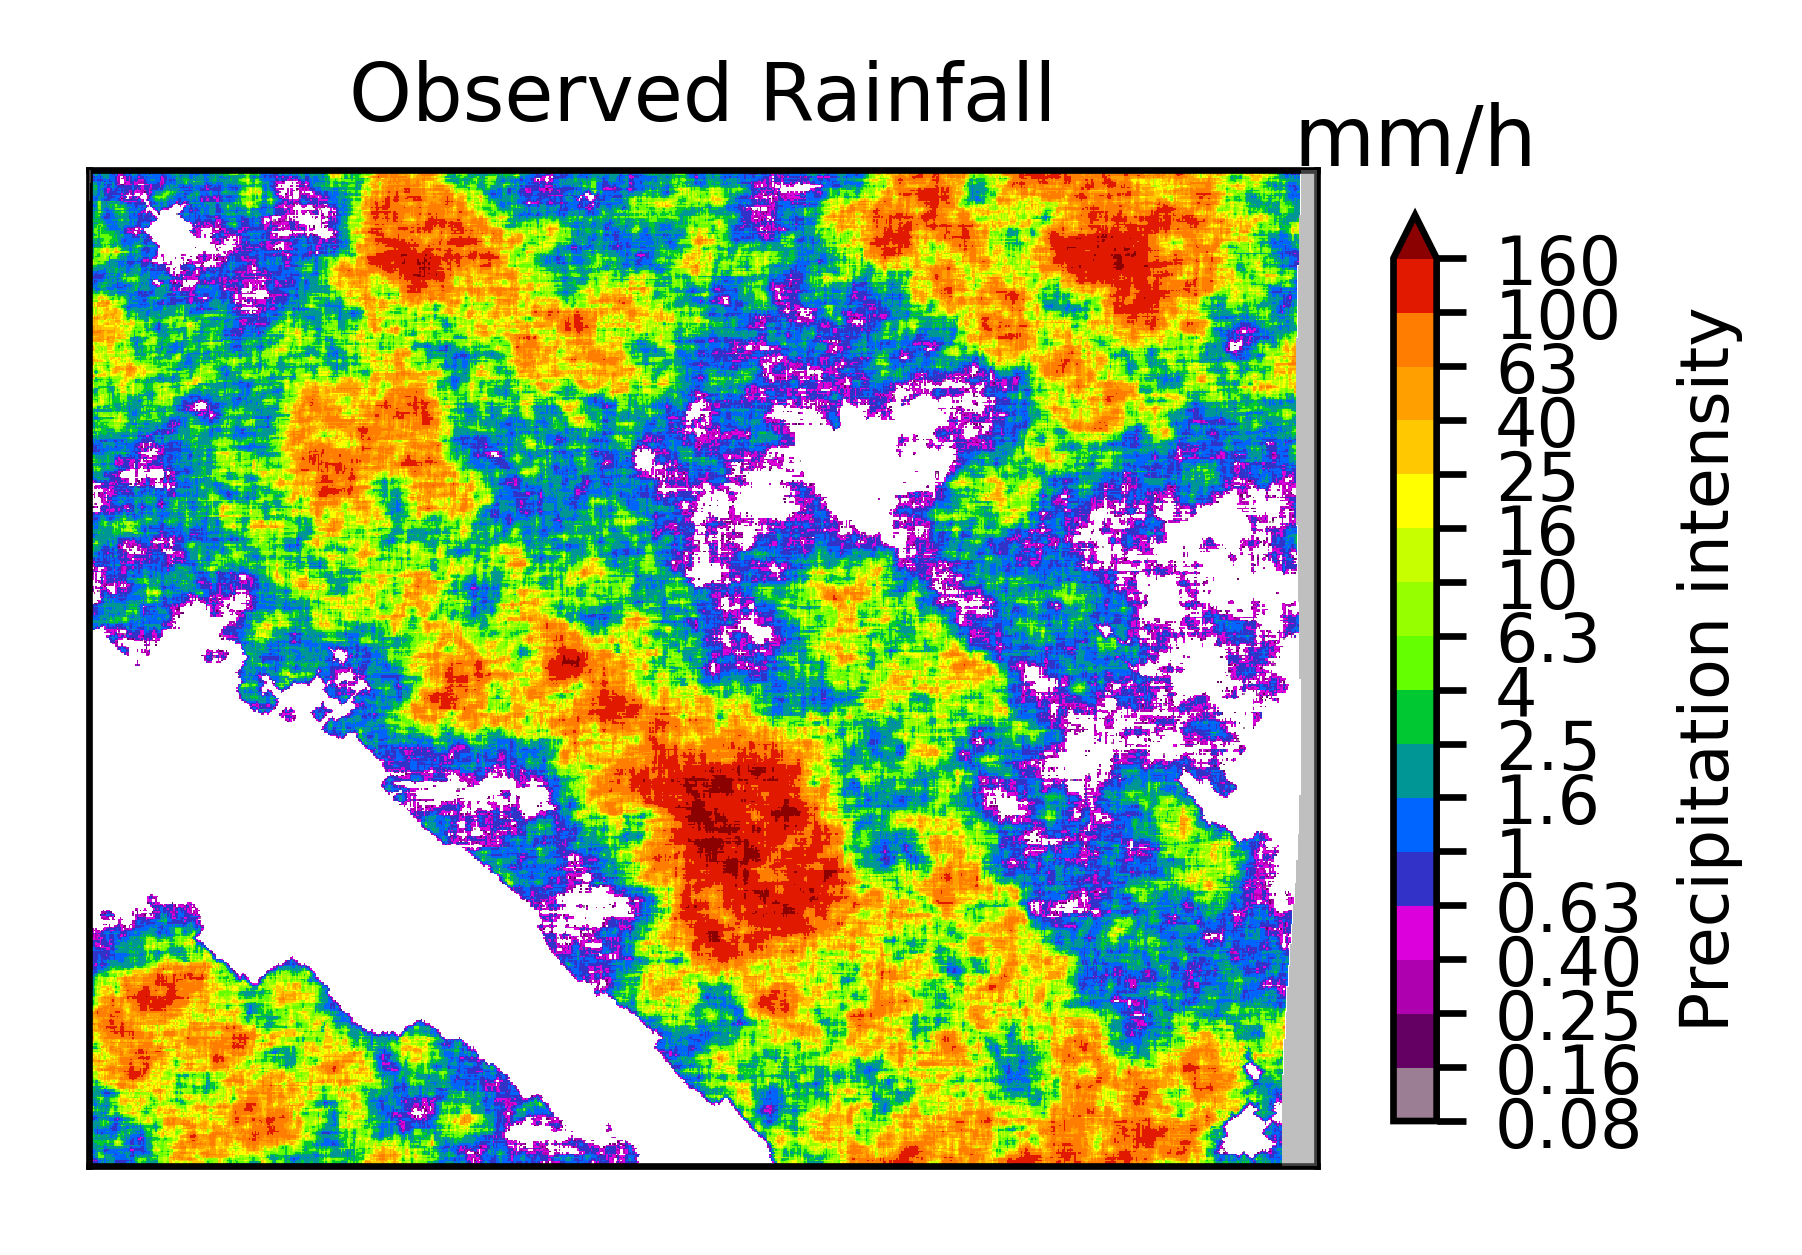

animation/None_frame_06.png saved.


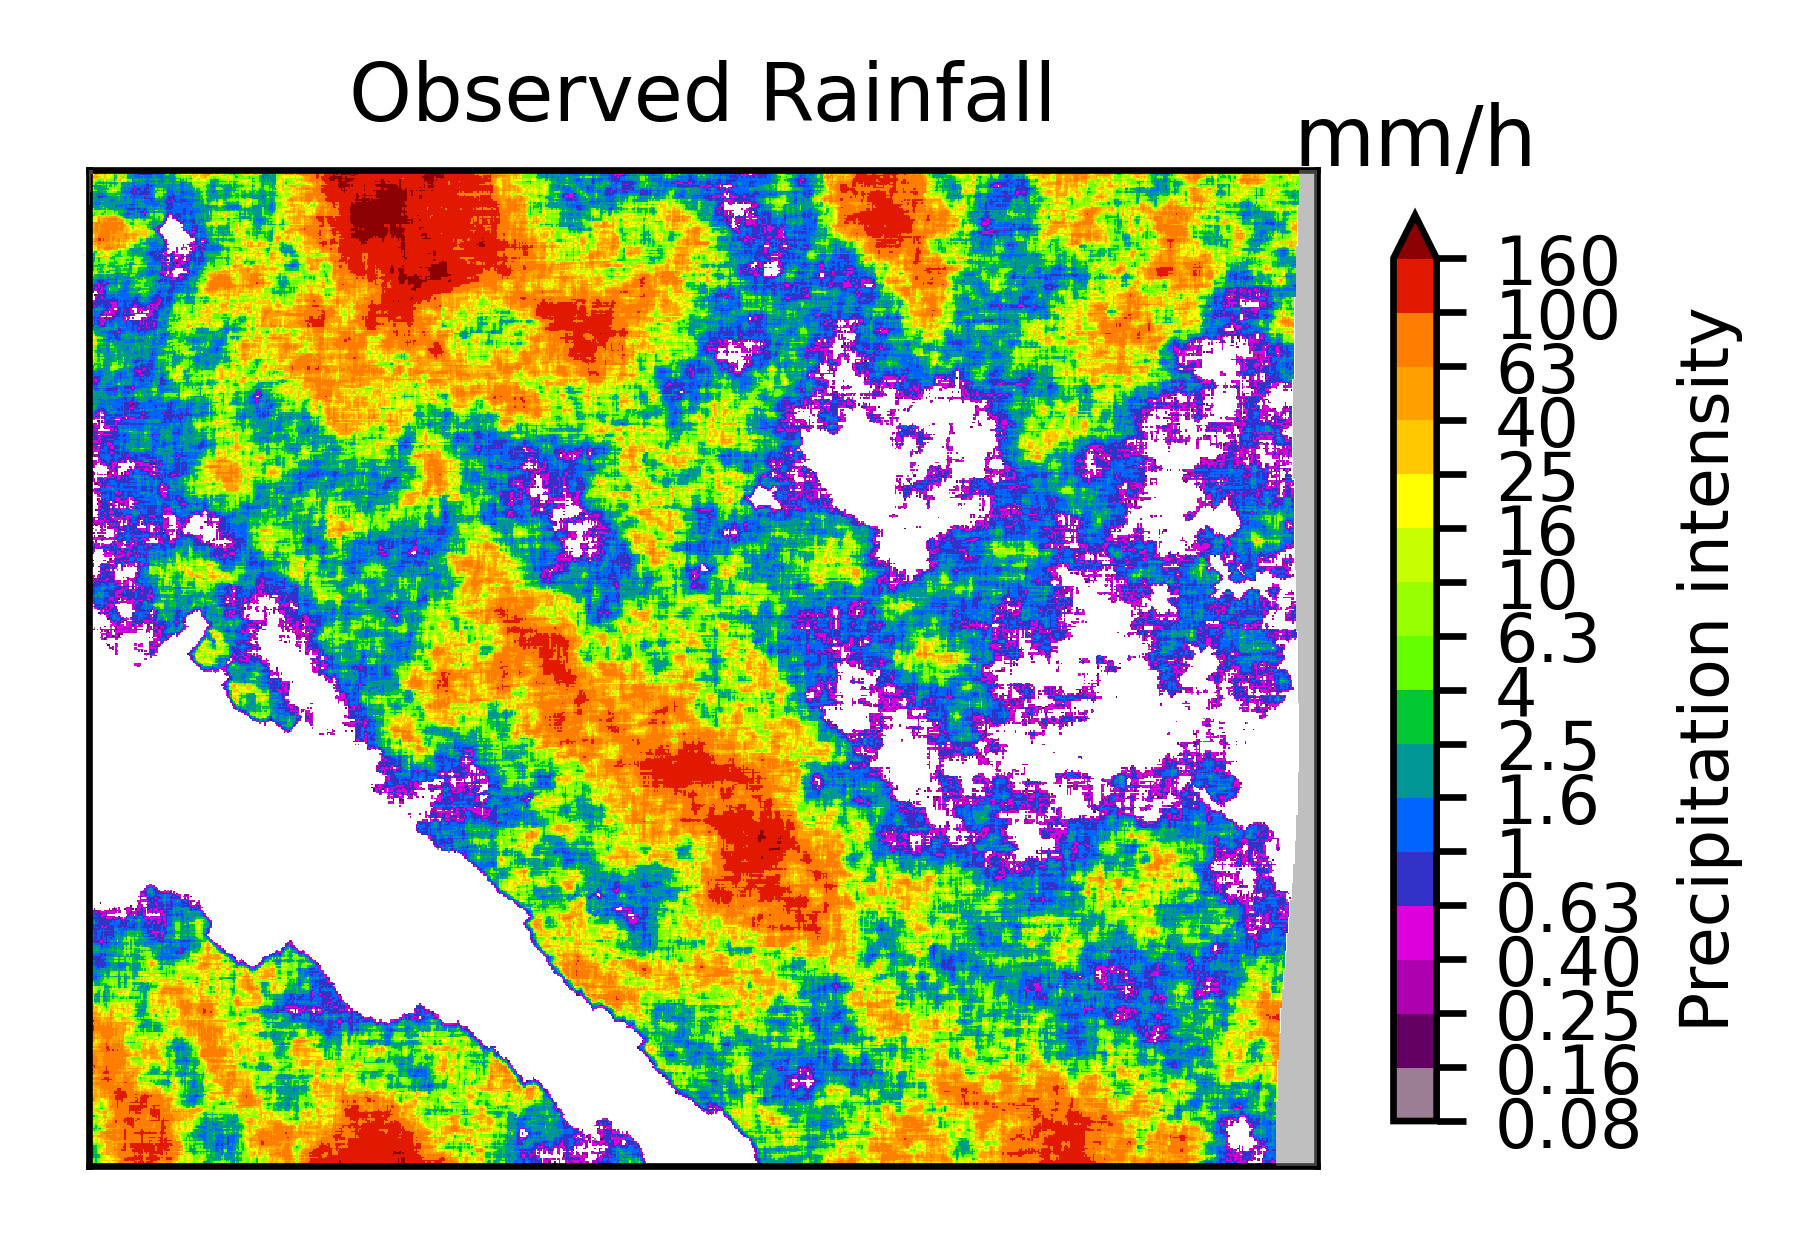

animation/None_frame_07.png saved.


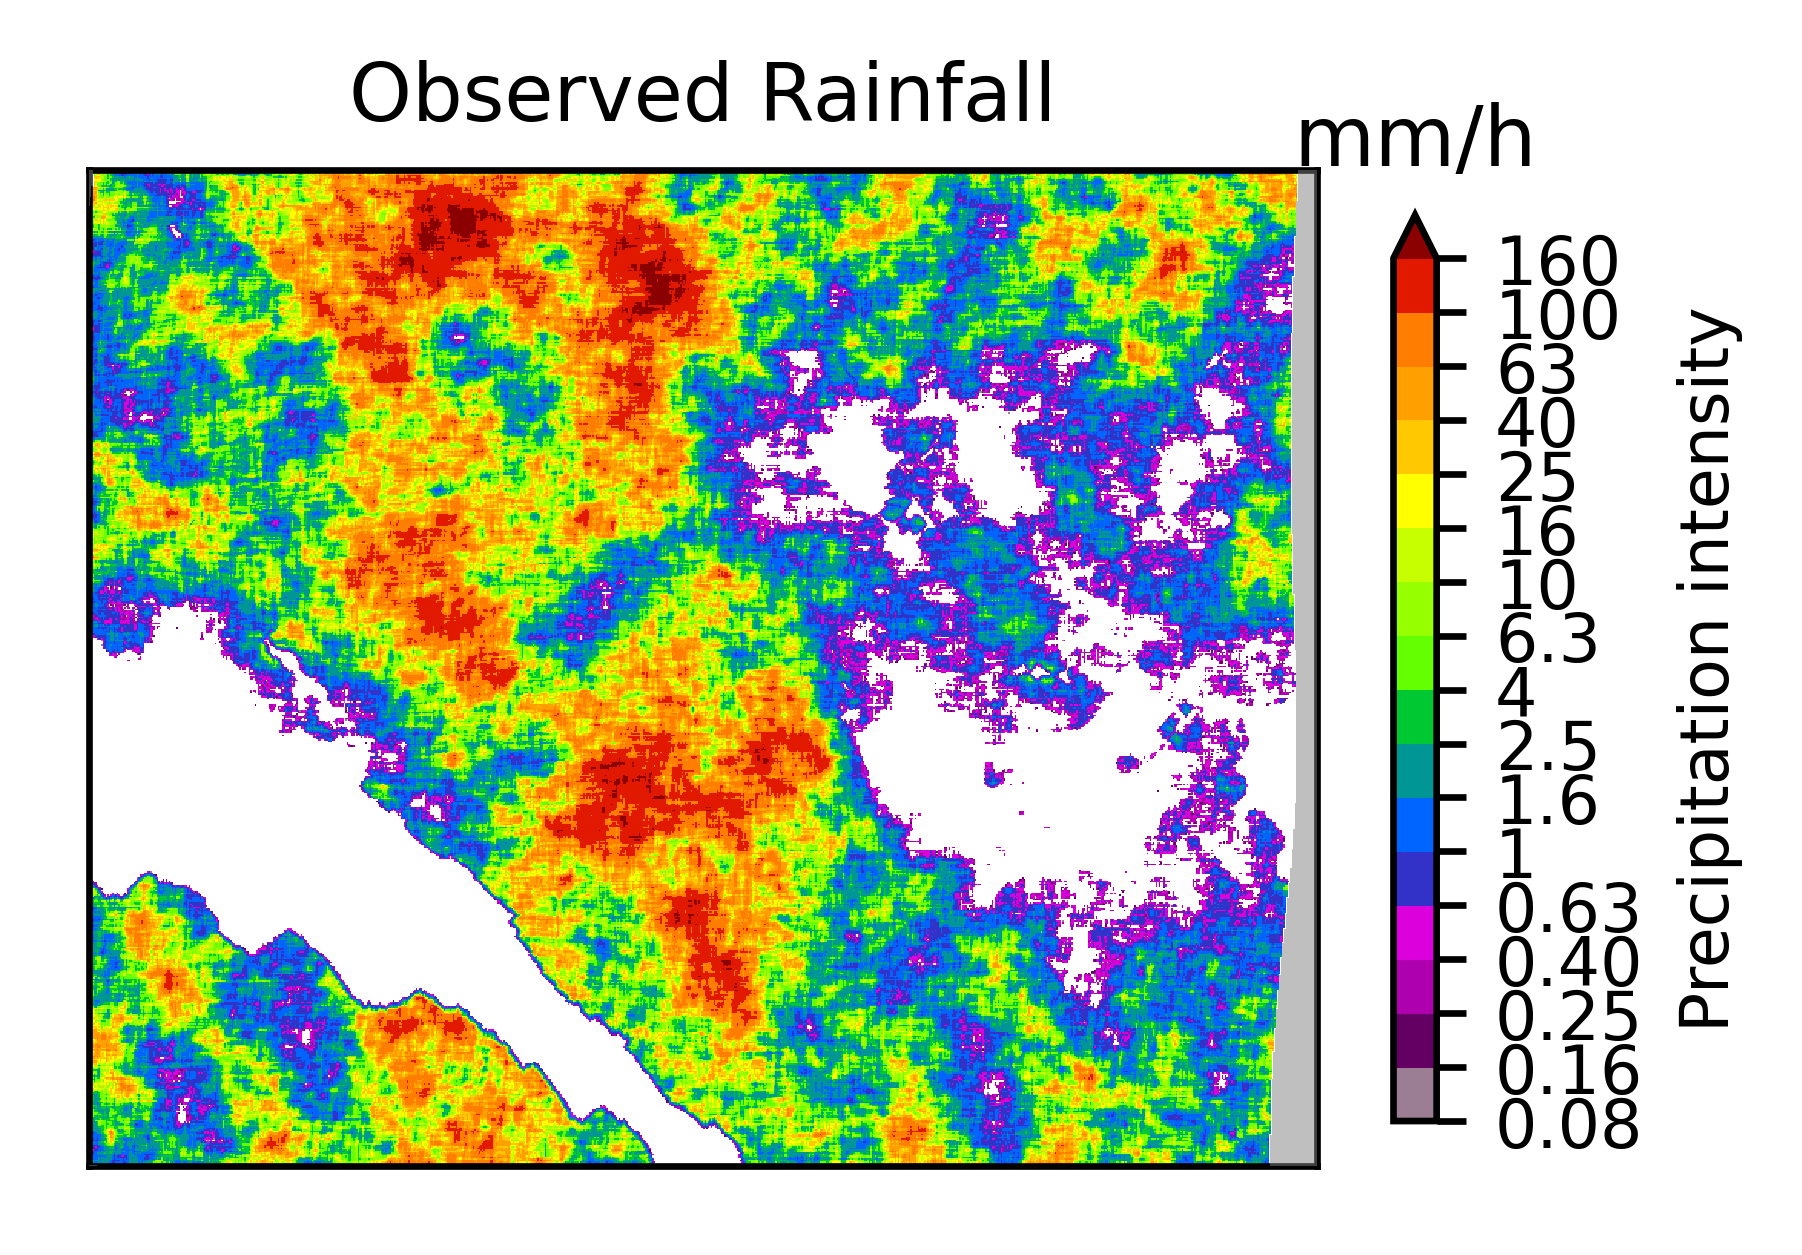

animation/None_frame_08.png saved.


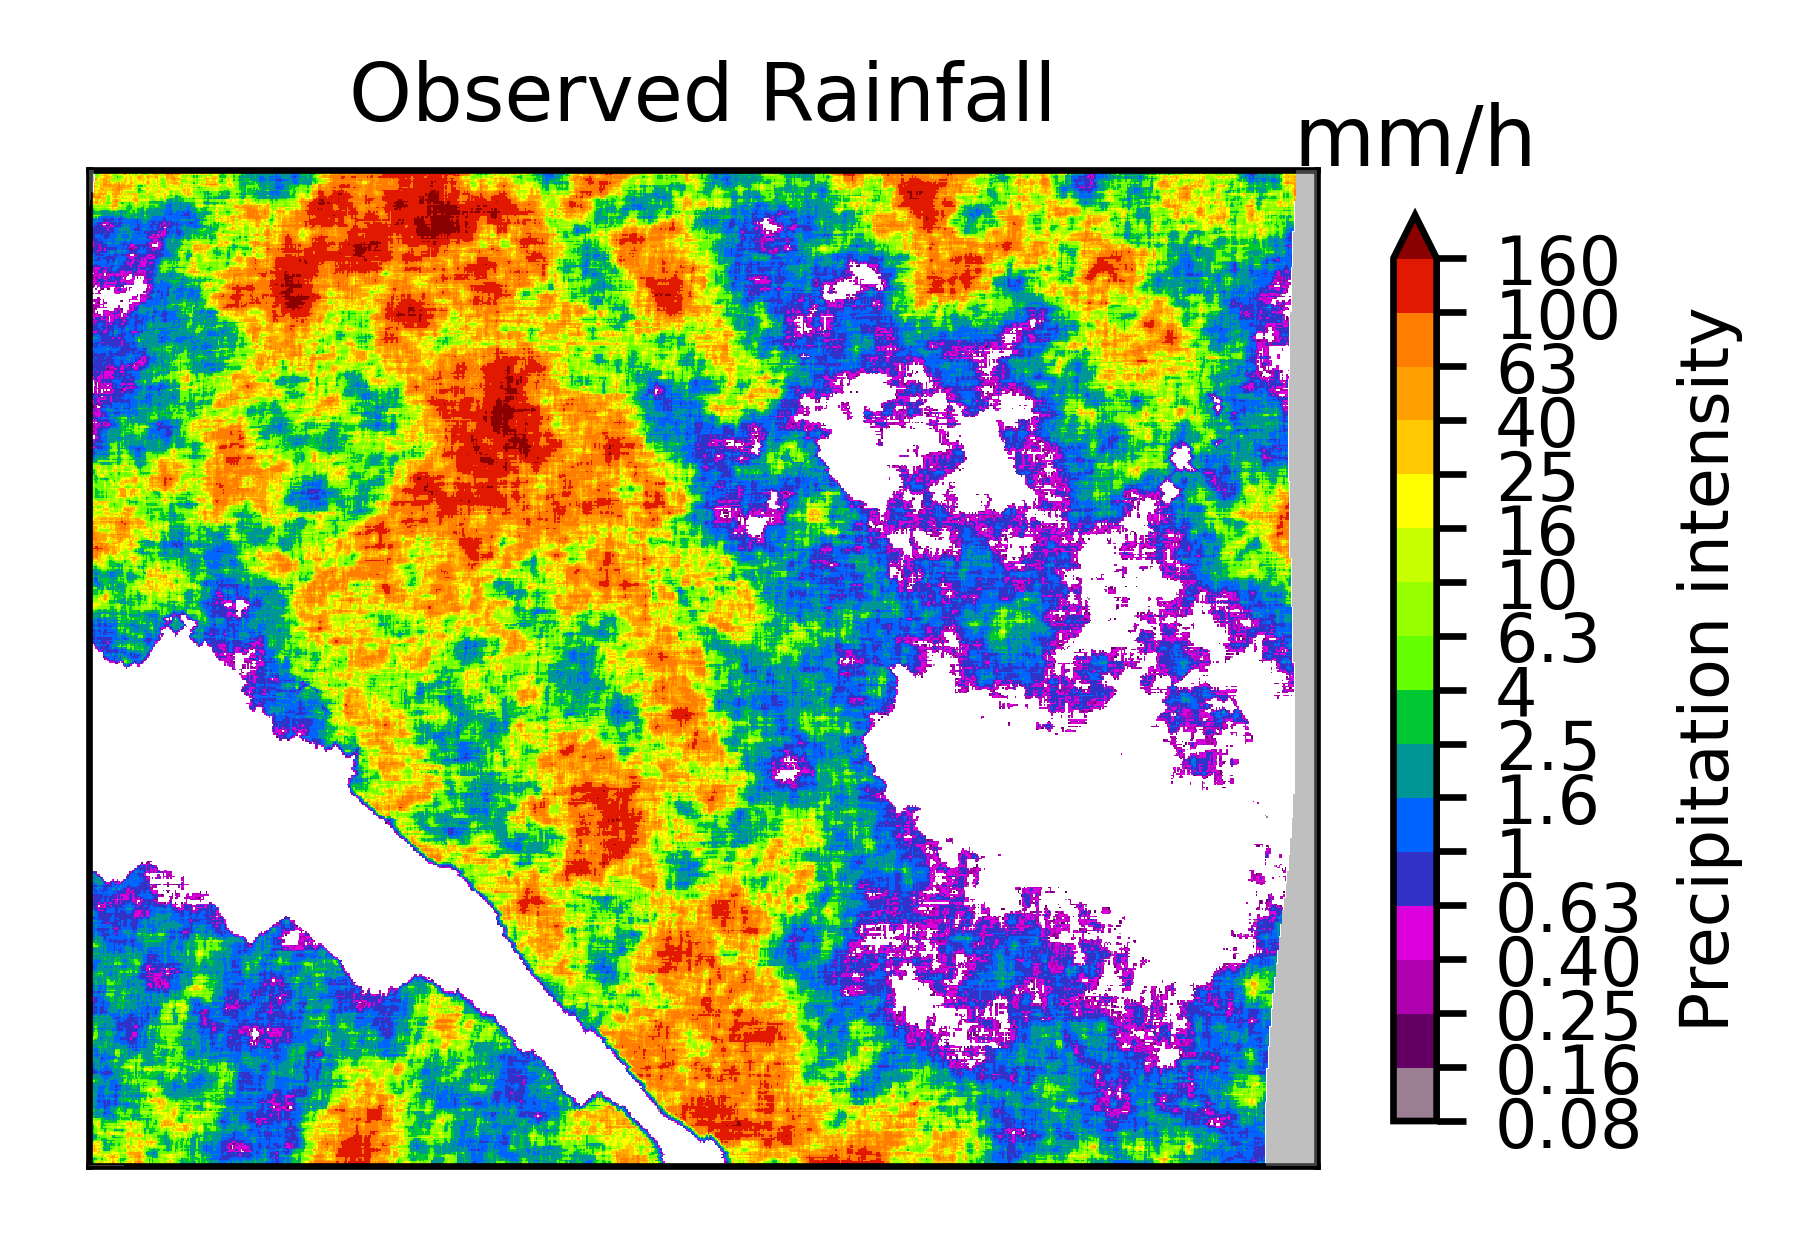

animation/None_frame_09.png saved.


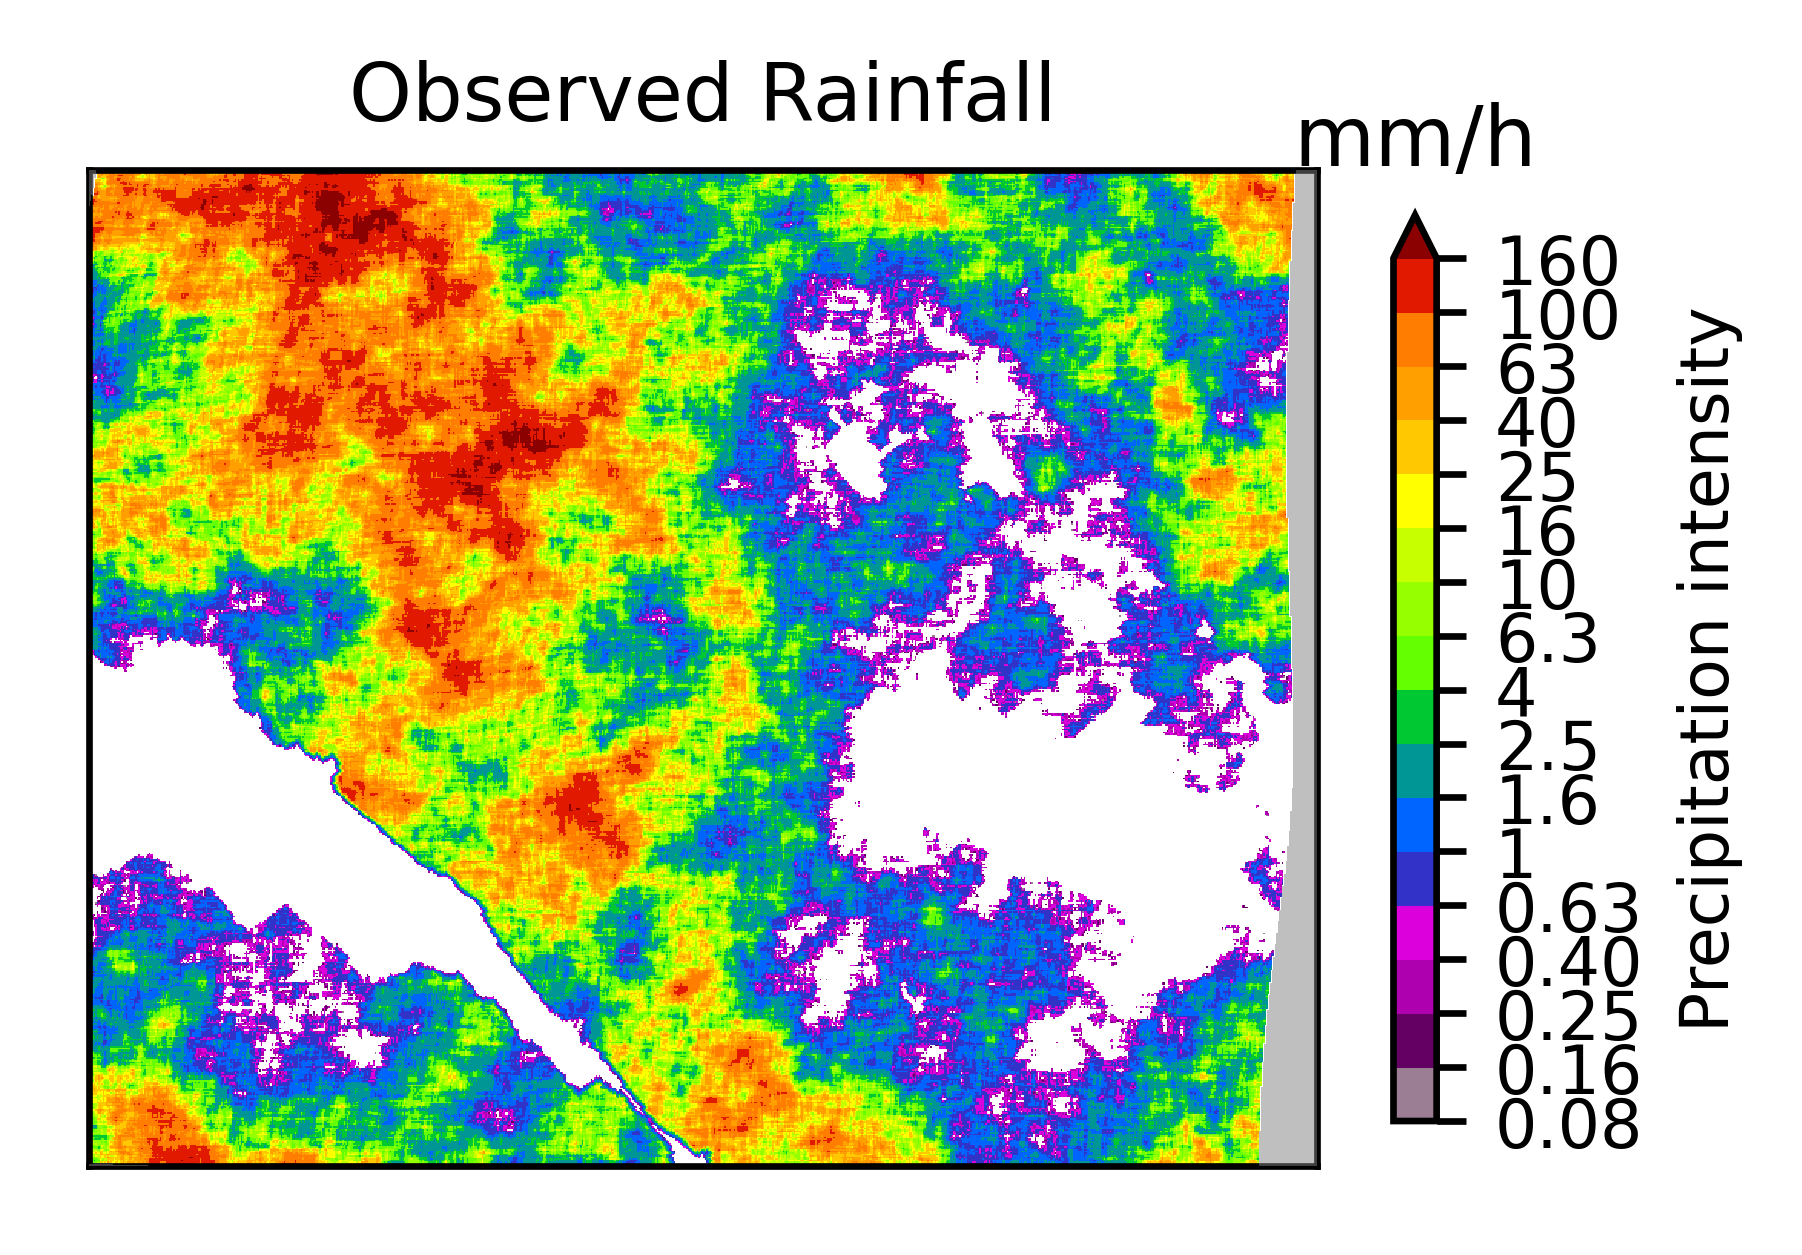

In [14]:
from IPython.display import HTML
animate(R_f[0],nloops=1,savefig=True,path_outputs='animation')
# animate= 

In [26]:
R= np.stack([gdal.Open(os.path.join(base_dir, fname.strftime('PrecipRate_00.00_%Y%m%d-%H%M%S.grib2-var0-z0.tif'))).ReadAsArray() \
                     for fname in fnames],axis=0)

In [16]:
for t in range(10):
    fig=plt.figure(figsize=(10,20))
    ax= fig.add_subplot(6,2,1)
    plot_precip_field(T[t],ax=ax, geodata=metadata)
    ax.set_title('%s'%dr[t].strftime('%Y%m%d%H%M%S'), weight='bold', fontsize=16)
    for i in range(10):
        ax= fig.add_subplot(6,2,i+2)
        ax.set_title('Member %d'%(i+1), weight='bold', fontsize=16)
        plot_precip_field(R_f[i,t],ax=ax, geodata=metadata)
    plt.tight_layout()
    fig.savefig('animation/None_t_%02d.png'%t)
    plt.close()

In [25]:
from osgeo import gdal

In [51]:
U_wind= gdal.Open('../hrrr.wind_vel_u_warp.tif').ReadAsArray()
V_wind= gdal.Open('../hrrr.wind_vel_v_warp.tif').ReadAsArray()

In [52]:
VELOCITY= np.stack([U_wind, -V_wind])

<AxesSubplot:>

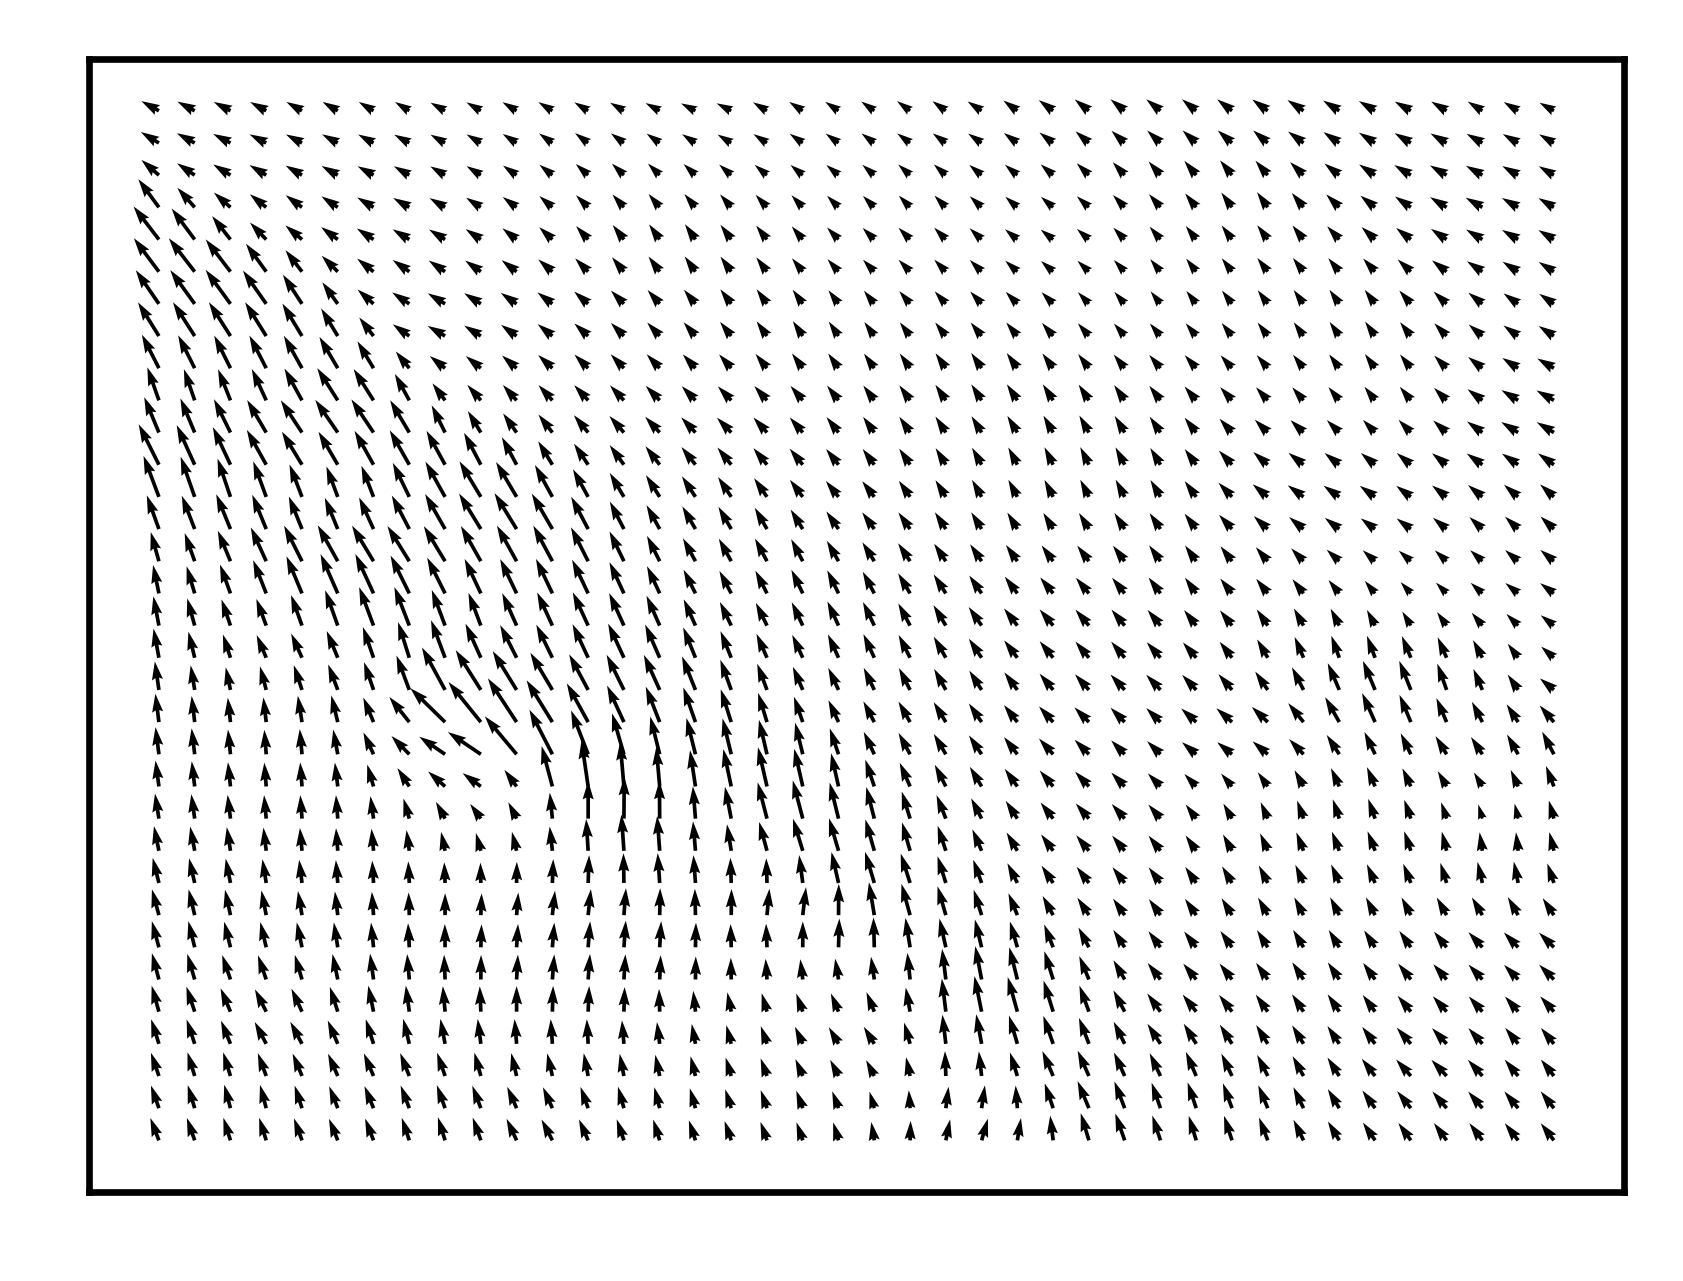

In [53]:
quiver(VELOCITY)

In [34]:
VELOCITY

array([[[ -4.51773907,  -4.53422061,  -4.55069671, ..., -10.17999684,
         -10.1845862 , -10.18434013],
        [ -4.49173014,  -4.50835308,  -4.52497059, ..., -10.19296232,
         -10.19737139, -10.19712532],
        [ -4.46572647,  -4.48249083,  -4.49924975, ..., -10.20592784,
         -10.21015662, -10.20991055],
        ...,
        [ -9.29818726,  -9.30111079,  -9.30403988, ..., -12.42865743,
         -12.42871963, -12.42878184],
        [ -9.31006588,  -9.31284645,  -9.31563258, ..., -12.4254541 ,
         -12.4255163 , -12.42557851],
        [ -9.32193917,  -9.32457678,  -9.32721995, ..., -12.42225076,
         -12.42231296, -12.42237517]],

       [[  0.22902058,  -0.25157521,  -0.27412439, ...,  -1.80951498,
          -1.80411858,  -1.79872219],
        [ -0.17434193,  -0.19703806,  -0.21972876, ...,  -1.8029421 ,
          -1.79754561,  -1.79214912],
        [ -0.11966845,  -0.14250609,  -0.16533831, ...,  -1.79636919,
          -1.79097261,  -1.78557603],
        ...,


In [33]:
V

array([[[-42.78468983, -42.85423064, -42.92351018, ..., -33.02170988,
         -33.03069933, -33.03946991],
        [-42.73421702, -42.82688801, -42.89587294, ..., -33.01713915,
         -33.0262511 , -33.03514412],
        [-42.70795322, -42.77586755, -42.84347969, ..., -33.01267073,
         -33.02190577, -33.03092181],
        ...,
        [-25.24454552, -25.23875268, -25.23281095, ..., -23.03976817,
         -22.95002259, -22.86003242],
        [-25.23694816, -25.23113866, -25.22518104, ..., -23.09407977,
         -23.00411772, -22.91389173],
        [-25.2293316 , -25.22350482, -25.21753075, ..., -23.14898797,
         -23.05882668, -22.96838199]],

       [[ 24.92987609, -24.75112881, -24.57230772, ..., -28.15040489,
         -28.16681884, -28.18303013],
        [-24.96338923, -24.75805017, -24.57973305, ..., -28.15651323,
         -28.17273446, -28.18875505],
        [-24.96863239, -24.79208798, -24.61551026, ..., -28.16274335,
         -28.17876933, -28.1945967 ],
        ...,


<AxesSubplot:>

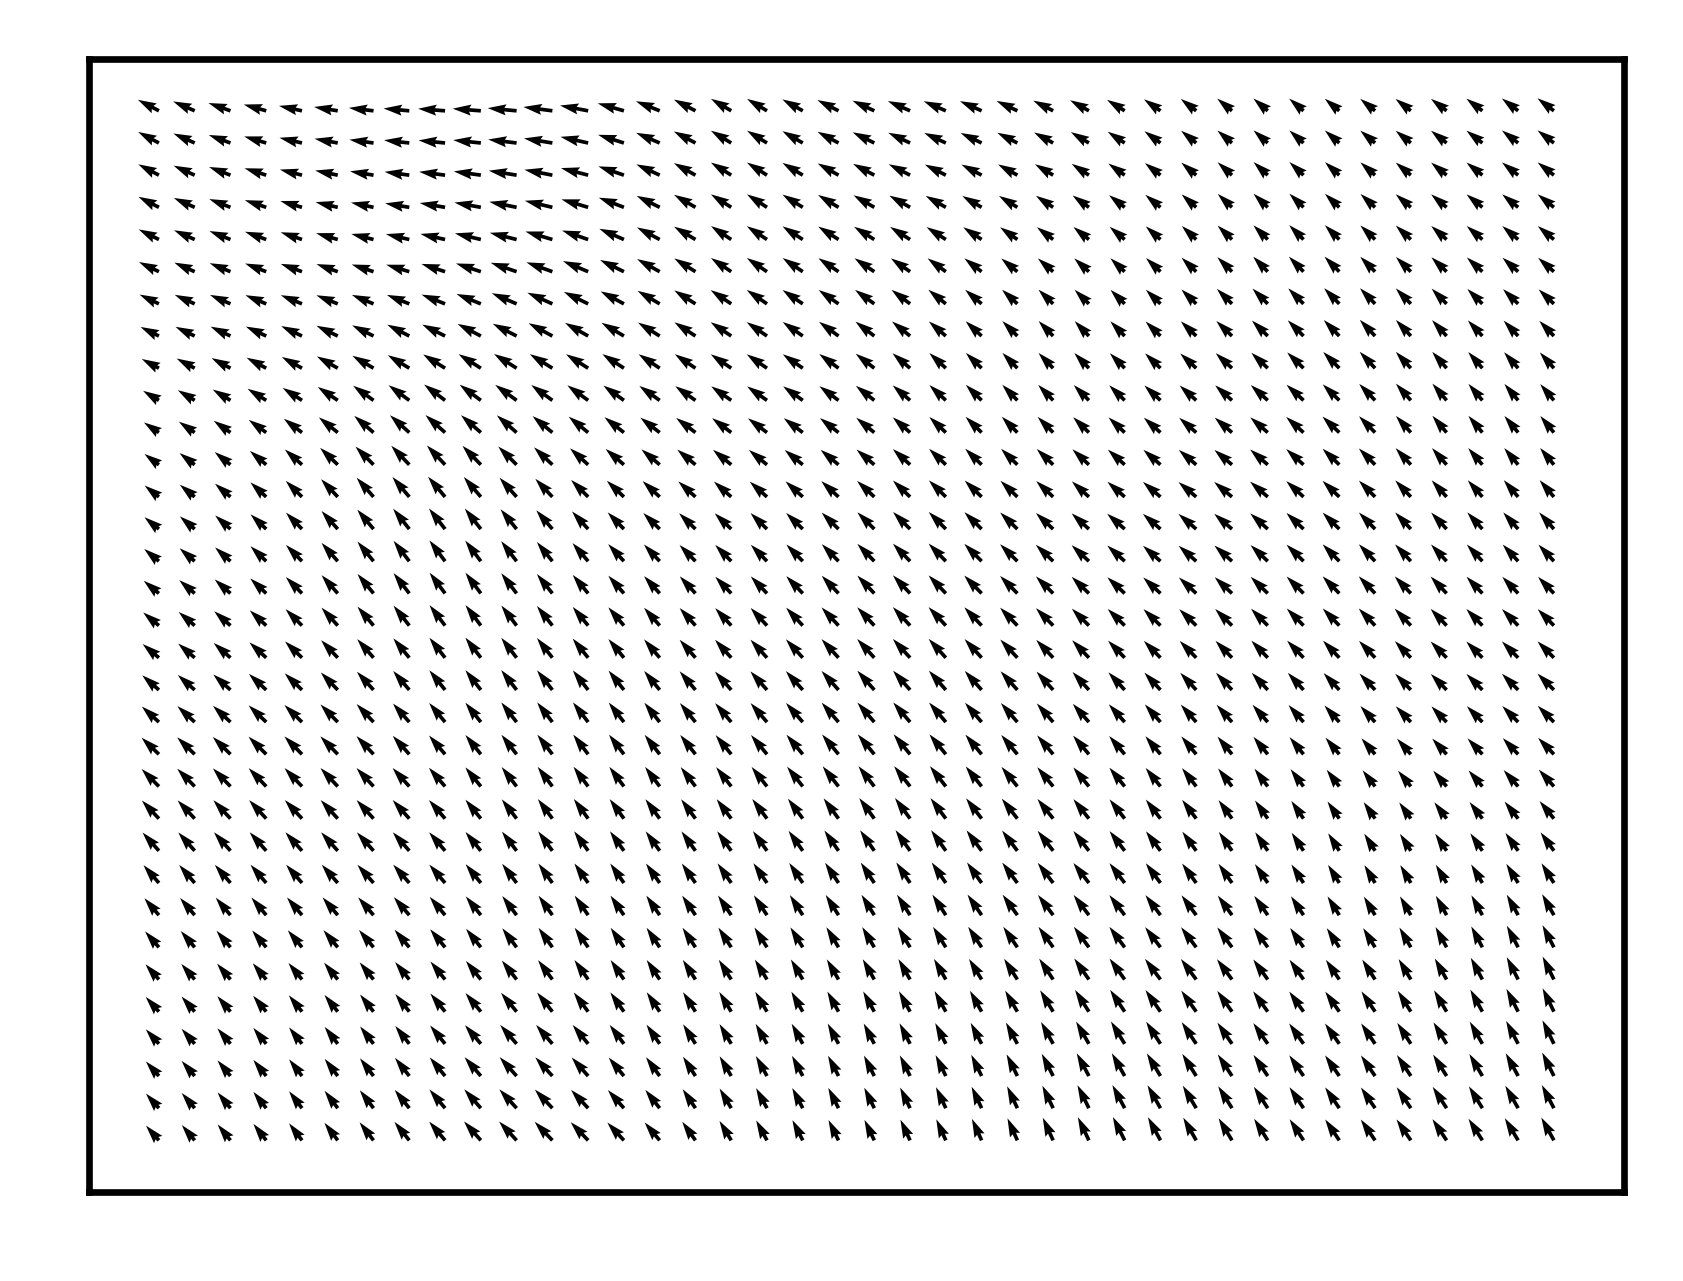

In [32]:
quiver(V)